In [1]:
import pandas as pd
import numpy as np

Parameters for the Analysis

In [2]:
analysis_years = np.arange(1997, 2015, 1) # 2015 data does not have International Sunspot Number, so excluding it

noaa_filenames =[]
noaa_DSD_filenames=[]
noaa_DPD_filenames=[]
for analysis_year in analysis_years: 
    noaa_filenames.append(str(analysis_year) + '.txt') 
    noaa_DSD_filenames.append(str(analysis_year) + '_DSD.txt')
    noaa_DPD_filenames.append(str(analysis_year) + '_DPD.txt')

Read in SOHO-LASCO CME Catalog (All Available Years)

In [3]:
# Import Catalog of Coronal Mass Ejection Data
# Data is in fixed width file format
data_file = 'SOHO-LASCO_CME_Catelog_univ_all.txt'
colspecs = [(0,10), (12,20), (24,27), (32,34), (37,41), (45,49), (52,56), (59,63), (66,72), (72,73), (76,83), (83,84), (87,94), (94,95), (98,101), (104, 147)]
names = ['Date', 'Time', 'CentralPA', 'Width', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'AFlag', 'Mass', 'MFlag', 'KineticEnergy', 'KEFlag', 'MPA',
'Remarks']
cme = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=4)
# Create the index as a datetime
cme.index = pd.to_datetime(cme.Date)

#cme.convert_objects(convert_numeric=True).dtypes # some columns can be converted 
cols_to_convert_to_float64 = ['CentralPA', 'LinearSpeed', 'Initial', 'Final', '20R', 'Accel', 'Mass', 'KineticEnergy']
for col in cols_to_convert_to_float64:
    cme[col] = pd.to_numeric(cme[col], errors='coerce')

cme = cme[(cme.index.year >= analysis_years[0]) & (cme.index.year <= analysis_years[len(analysis_years) - 1])]
cme.shape

(24648, 16)

Create a series to analyze Linear Speed.  Create 1 entry per date with max of LinearSpeed

In [4]:
linear_max = cme.groupby([cme.index])['LinearSpeed'].max()
#linear_max = linear_max[(linear_max.index.year==analysis_year)]


Create a series to analyze 20R - the speed at 20 Solar Radii.  Create 1 entry per date using the max of 20R

In [5]:
c20R_max = cme.groupby([cme.index])['20R'].max()
#c20R_max = c20R_max[(c20R_max.index.year==analysis_year)]

Create a series that is the count of the cme's on a particular date

In [6]:
cme_count = cme.groupby([cme.index])['Date'].count()

Read in NOAA files of Geomagnetic data

In [7]:

colspecs = [(0,2), (2,4), (4,6), (6,10), (10,12), (12,14), (14,16), (16,18), (18,20), (20,22), (22,24), (24,26), (26,28), (28,30), 
            (58,60), (61, 62), (62,65)]
names = ['Year', 'Month', 'Day', 'Bartels', 'BDay', 'Kp0', 'Kp3', 'Kp6', 'Kp9', 'Kp12', 'Kp15', 'Kp18', 'Kp21', 'KpSum', 'Cp',
'C9', 'ISN']

first_file = True

for data_file in noaa_filenames:
    if first_file:
        noaa = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        first_file = False
    else:
        noaa_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs)
        noaa = pd.concat([noaa, noaa_file])


In [8]:
noaa.loc[noaa['Year']>=95,['Year']] = 1900 + noaa.loc[noaa['Year']>=95,['Year']]
noaa.loc[noaa['Year']<=15,['Year']] = 2000 + noaa.loc[noaa['Year']<=15,['Year']]

# Create datetime index using the individual columns for Year, Month and Day
str_date =  noaa.Year.astype(str) + '/' + noaa.Month.astype(str) + '/' + noaa.Day.astype(str)
noaa['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa.index = noaa.Date
noaa['ISN'] = pd.to_numeric(noaa['ISN'], errors='coerce')

In [9]:
# Time shifting the C9 data in 1 day increments for 5 days so that we can compare solar activity to future space weather on Earth
C9 = noaa.C9
for n in range(5,-6,-1):
        shifted_forward =  C9.shift(n)  
        if n > 0:
                rsuffix =  str(-n)
        elif n < 0:
                rsuffix = '+' + str(-n)
        else:
                rsuffix = '_0'
                
        noaa = noaa.join(shifted_forward, rsuffix=rsuffix)
 
noaa.tail()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,C9-4,C9-3,C9-2,C9-1,C9_0,C9+1,C9+2,C9+3,C9+4,C9+5
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-27,2014,12,27,2474,27,33,20,13,17,17,...,3.0,4.0,3.0,4.0,1,2.0,5.0,4.0,2.0,NaN
2014-12-28,2014,12,28,2475,1,23,20,13,13,13,...,4.0,3.0,4.0,1.0,2,5.0,4.0,2.0,NaN,NaN
2014-12-29,2014,12,29,2475,2,20,30,23,33,37,...,3.0,4.0,1.0,2.0,5,4.0,2.0,NaN,NaN,NaN
2014-12-30,2014,12,30,2475,3,30,40,37,20,30,...,4.0,1.0,2.0,5.0,4,2.0,NaN,NaN,NaN,NaN
2014-12-31,2014,12,31,2475,4,13,23,13,17,20,...,1.0,2.0,5.0,4.0,2,NaN,NaN,NaN,NaN,NaN


Read in the Daily Solar Data

In [10]:

colspecs = [(0,4), (5,7), (8,10), (12,16), (19,23), (27,32), (36,39), (49,54), (55,57), (58,60), (61,63), (64,66), (68,70), (71,73), 
            (74,76)]
names = ['Year', 'Month', 'Day', 'RadioFlux', 'SESC_SSN', 'SS_AREA', 'NEW_REGIONS', 'XrayBgndFlux', 'C', 'M', 'X', 'S', 'Opt1', 'Opt2', 'Opt3']

first_file = True

for data_file in noaa_DSD_filenames:
    if first_file:
        noaa_DSD = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        first_file = False
    else:
        noaa_DSD_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        noaa_DSD = pd.concat([noaa_DSD, noaa_DSD_file])

# Create datetime index using the individual columns for Year, Month and Day
str_date = noaa_DSD.Year.astype(str) + '/' + noaa_DSD.Month.astype(str) + '/' + noaa_DSD.Day.astype(str)
noaa_DSD.to_csv('../data/noaa_DSD.csv')
str_date
noaa_DSD['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa_DSD.index = noaa_DSD.Date
noaa_DSD.drop(['Year', 'Month', 'Day', 'Date'], axis=1, inplace=True)



Read in the Daily Particle Data

In [11]:
colspecs = [(0,4), (5,7), (8,10), (14,21), (23,30), (32,39), (42,49), (53,60)]
names = ['Year', 'Month', 'Day', 'P1MeV', 'P10MeV', 'P100MeV', 'E08MeV', 'E2MeV']

first_file = True

for data_file in noaa_DPD_filenames:
    if first_file:
        noaa_DPD = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        first_file = False
    else:
        noaa_DPD_file = pd.read_fwf('../data/' + data_file, header=None, names = names, colspecs=colspecs, skiprows=12)
        noaa_DPD = pd.concat([noaa_DPD, noaa_DPD_file])

# Create datetime index using the individual columns for Year, Month and Day
str_date = noaa_DPD.Year.astype(str) + '/' + noaa_DPD.Month.astype(str) + '/' + noaa_DPD.Day.astype(str)
noaa_DPD.to_csv('../data/noaa_DPD.csv')

noaa_DPD['Date'] = pd.to_datetime(str_date, yearfirst=True)
noaa_DPD.index = noaa_DPD.Date
noaa_DPD.drop(['Year', 'Month', 'Day', 'Date'], axis=1, inplace=True)




Concatenate all the datasets together by date

In [12]:
result = pd.concat([ noaa, noaa_DSD, noaa_DPD, linear_max, c20R_max, cme_count], axis=1)
new_columns = result.columns.values
new_columns[len(new_columns)-3] = 'LinearSpeed_max'
new_columns[len(new_columns)-2] = '20R_max'
new_columns[len(new_columns)-1] = 'CME_daily_count'
result.columns = new_columns

result.shape

(6574, 49)

Set NaN values for LinearSpeed_max, 20R_max, and CME_daily_count to 0 indicated there were no recorded CME's on that date.

In [13]:
result.loc[result.LinearSpeed_max.isnull(), ['LinearSpeed_max']]=0
result.loc[result['20R_max'].isnull(), ['20R_max']]=0
result.loc[result.CME_daily_count.isnull(), ['CME_daily_count']]=0


Drop the redundant date column

In [14]:
result.drop('Date', axis=1, inplace=True)

In [15]:
# Correct for NaN data.  
result.loc[result.P1MeV.isnull(), 'P1MeV'] = result.P1MeV.mean()
result.loc[result.P10MeV.isnull(), 'P10MeV'] = result.P10MeV.mean()
result.loc[result.P100MeV.isnull(), 'P100MeV'] = result.P100MeV.mean()

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

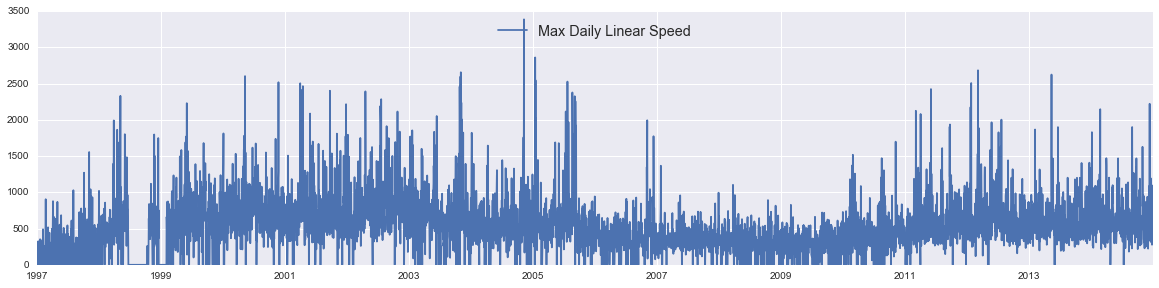

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.LinearSpeed_max, Label='Max Daily Linear Speed')
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/LinearSpeed_max.png', bbox_inches='tight')

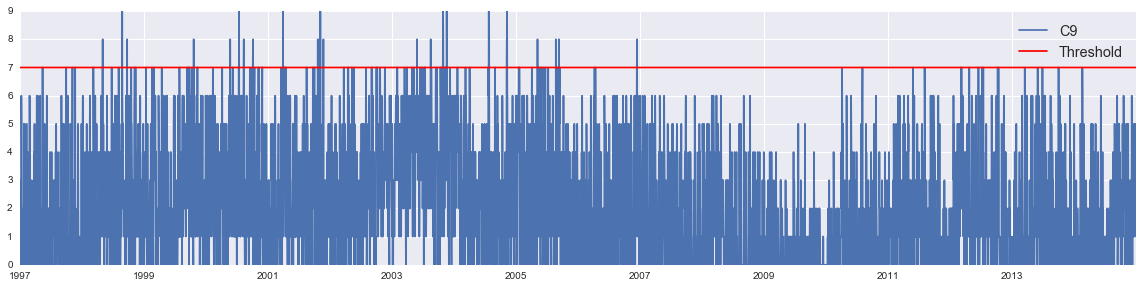

In [18]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['C9'], Label='C9')
a = np.empty(len(result.index))
a.fill(7)
plt.plot(result.index, a, Label = 'Threshold', color='red')
legend = plt.legend(loc='upper right', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/C9.png', bbox_inches='tight')

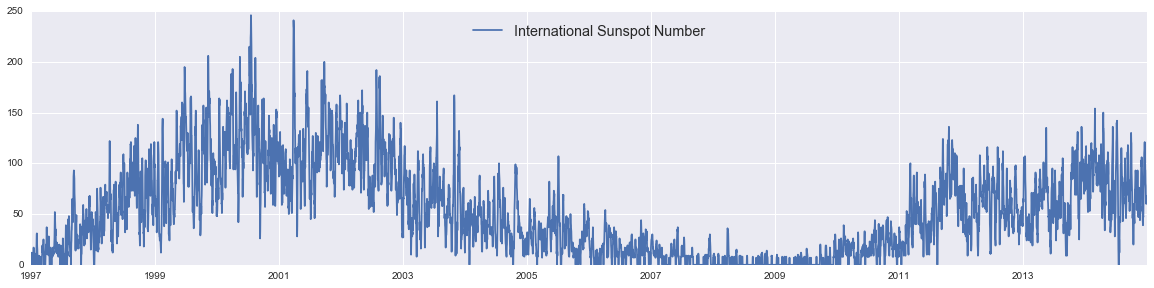

In [19]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['ISN'], Label="International Sunspot Number")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/ISN.png', bbox_inches='tight')

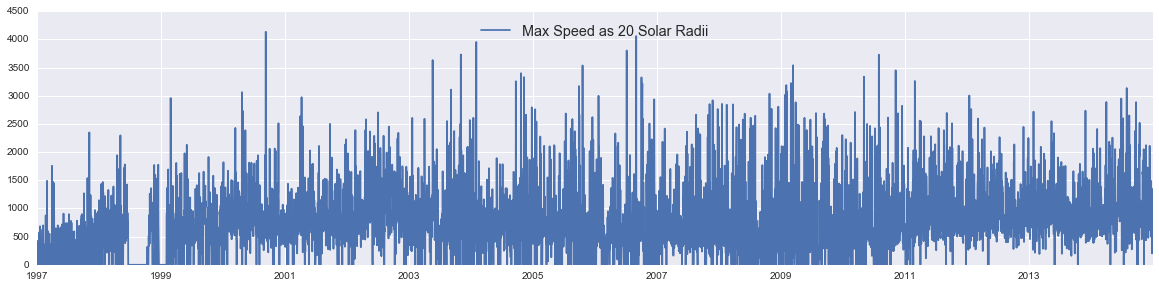

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(212)
plt.plot(result.index, result['20R_max'], Label="Max Speed as 20 Solar Radii")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/20R_max.png', bbox_inches='tight')

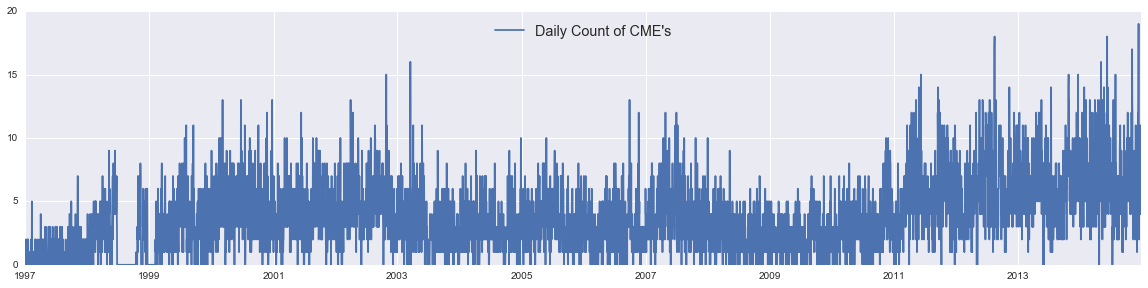

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['CME_daily_count'], Label="Daily Count of CME's")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.show()

plt.savefig('../images/DailyCountCMEs.png', bbox_inches='tight')

feature_cols = ['LinearSpeed_max']
X = result[feature_cols]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

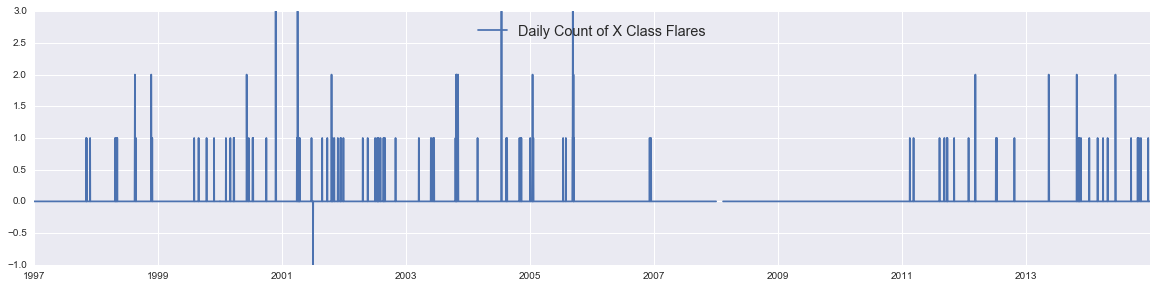

In [22]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['X'], Label="Daily Count of X Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
#plt.show()

plt.savefig('../images/X_Flares.png', bbox_inches='tight')

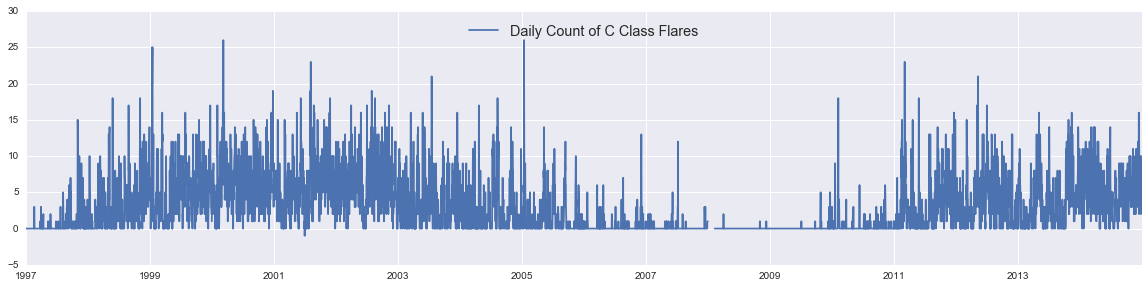

In [23]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['C'], Label="Daily Count of C Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/C_Flares.png', bbox_inches='tight')

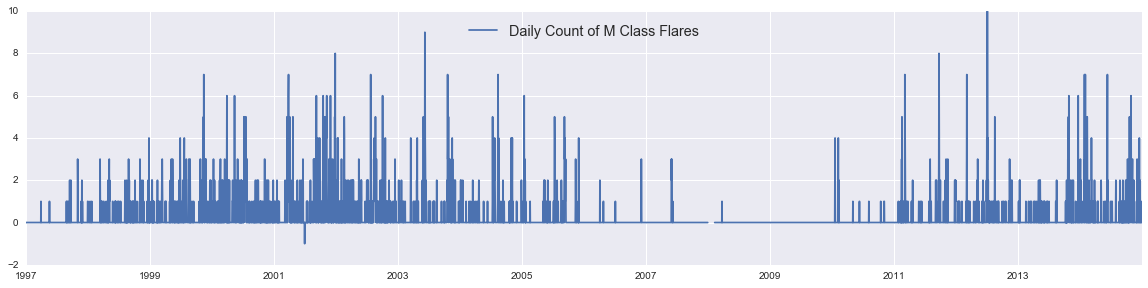

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result['M'], Label="Daily Count of M Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/M_Flares.png', bbox_inches='tight')

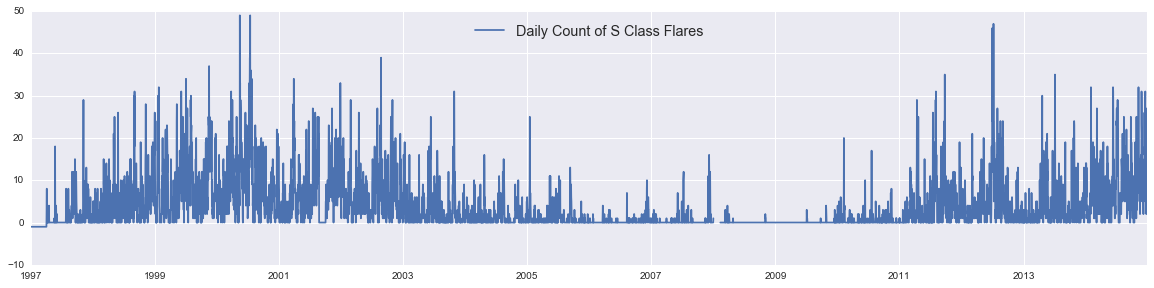

In [25]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(result.index, result['S'], Label="Daily Count of S Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/S_Flares.png', bbox_inches='tight')

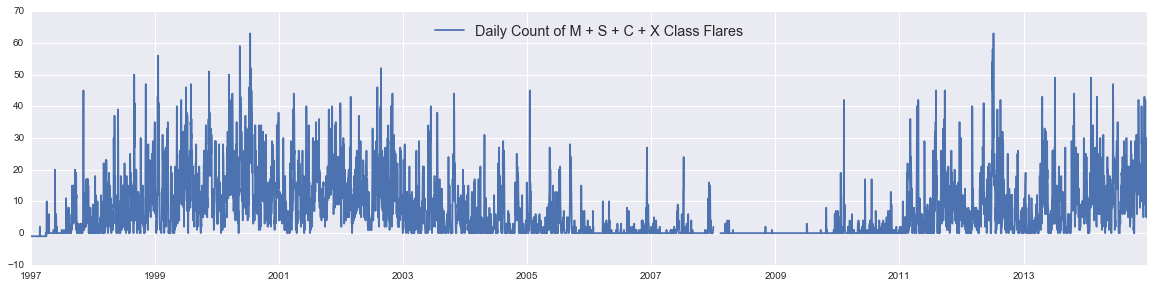

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.M + result.S + result.C + result.X, Label="Daily Count of M + S + C + X Class Flares")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/S_C_M_X_Flares.png', bbox_inches='tight')

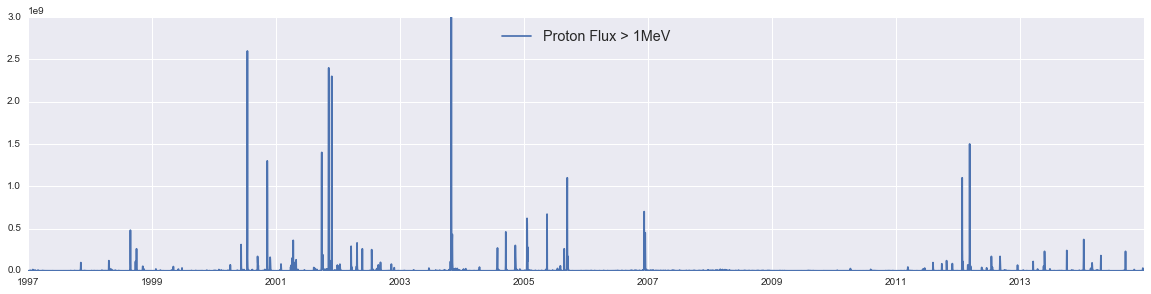

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P1MeV, Label="Proton Flux > 1MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton1MeV.png', bbox_inches='tight')

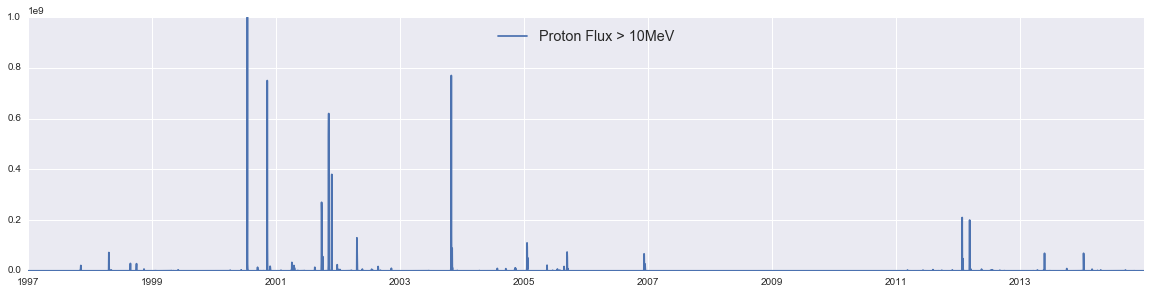

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P10MeV, Label="Proton Flux > 10MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton10MeV.png', bbox_inches='tight')

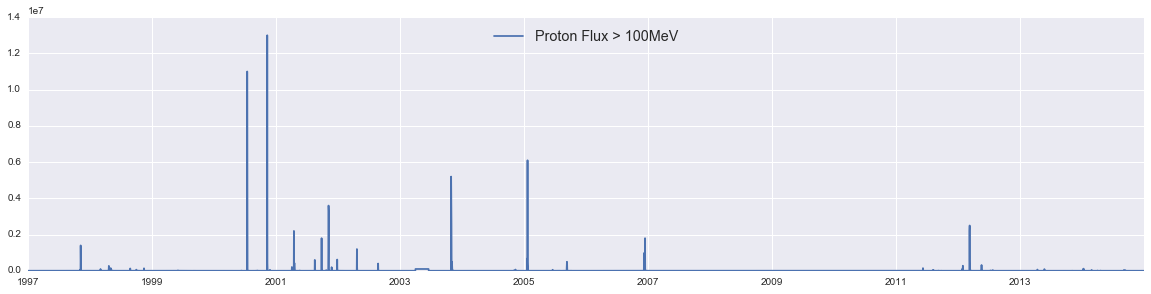

In [29]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.P100MeV, Label="Proton Flux > 100MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Proton100MeV.png', bbox_inches='tight')

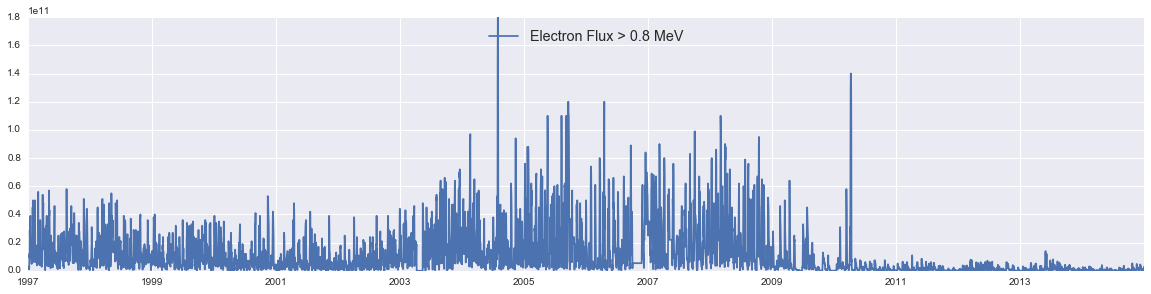

In [30]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.E08MeV, Label="Electron Flux > 0.8 MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Electron0_8MeV.png', bbox_inches='tight')

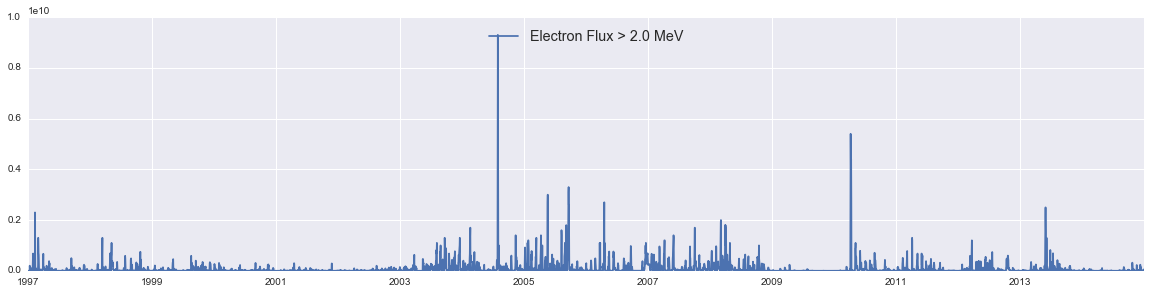

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(result.index, result.E2MeV, Label="Electron Flux > 2.0 MeV")
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

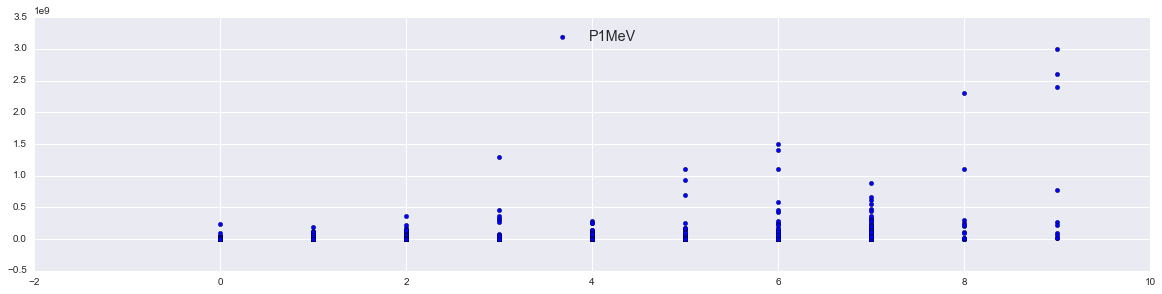

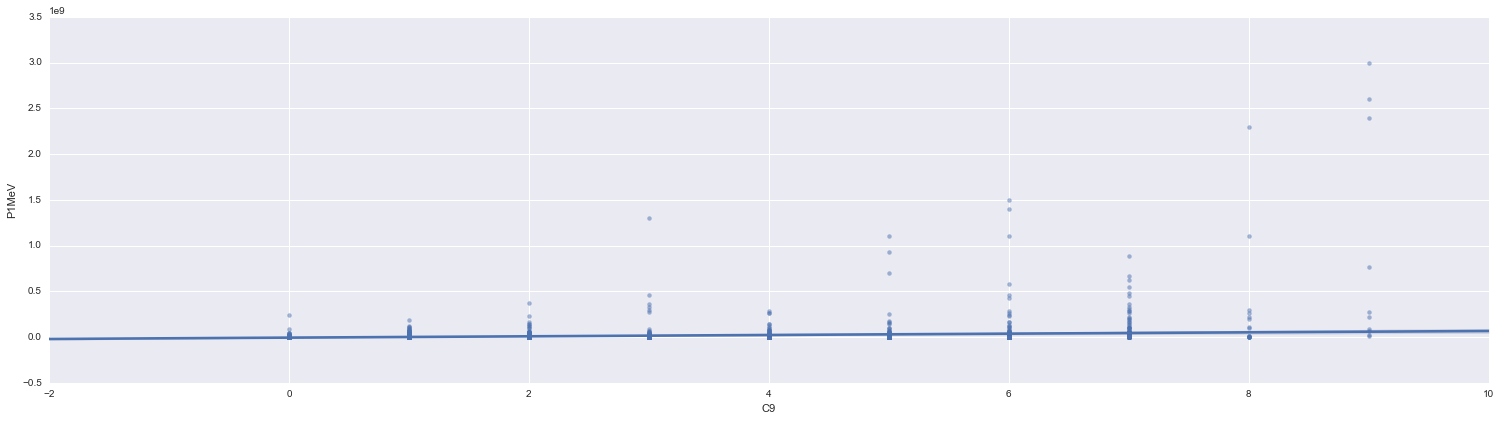

In [32]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P1MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P1MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

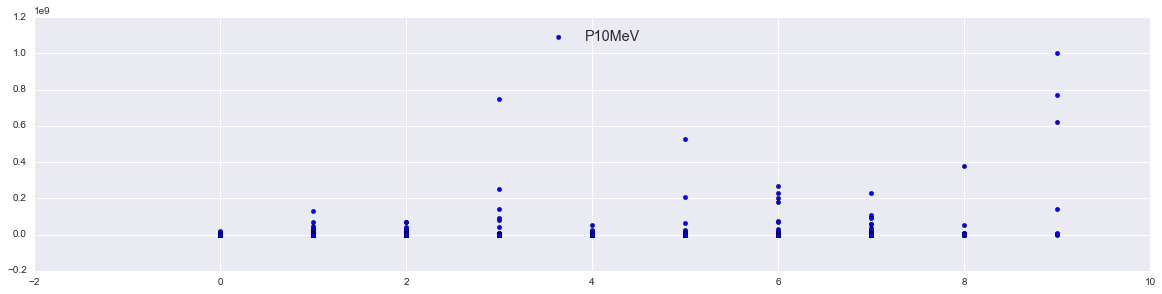

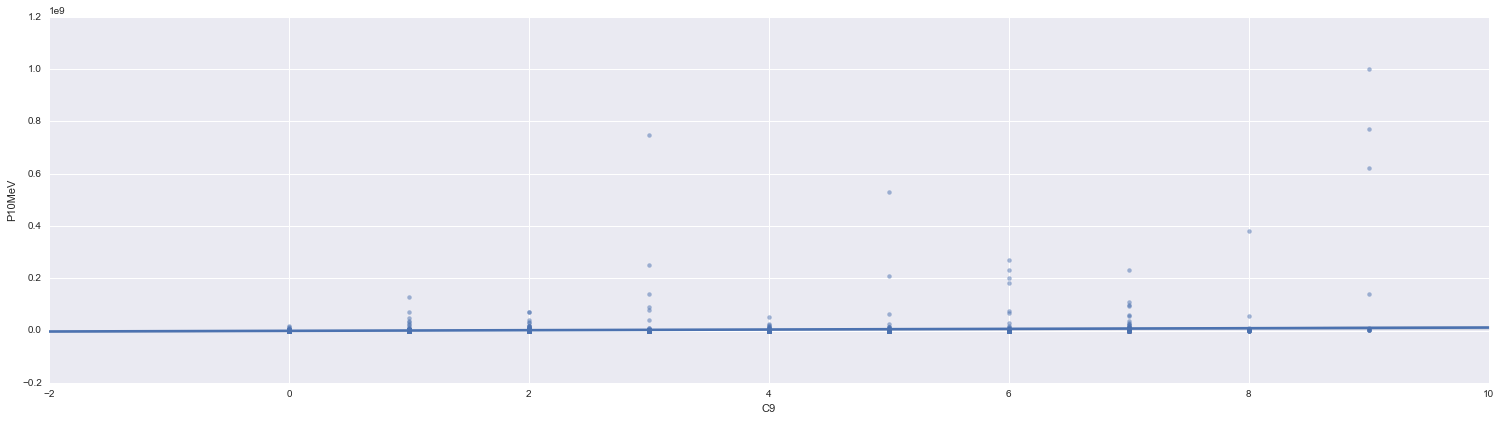

In [33]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P10MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P10MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

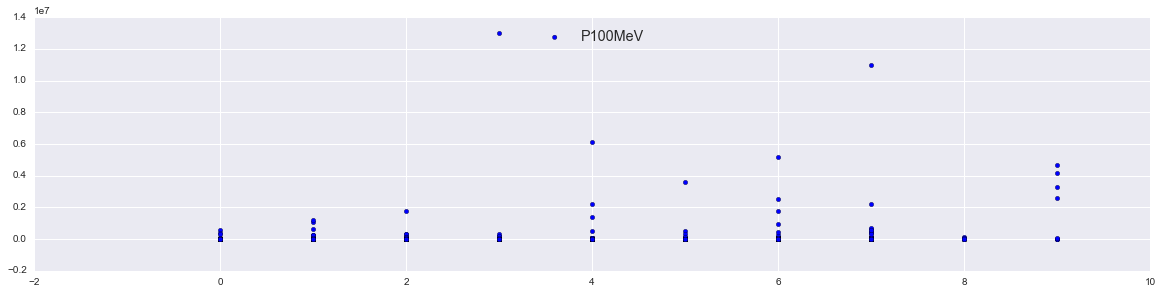

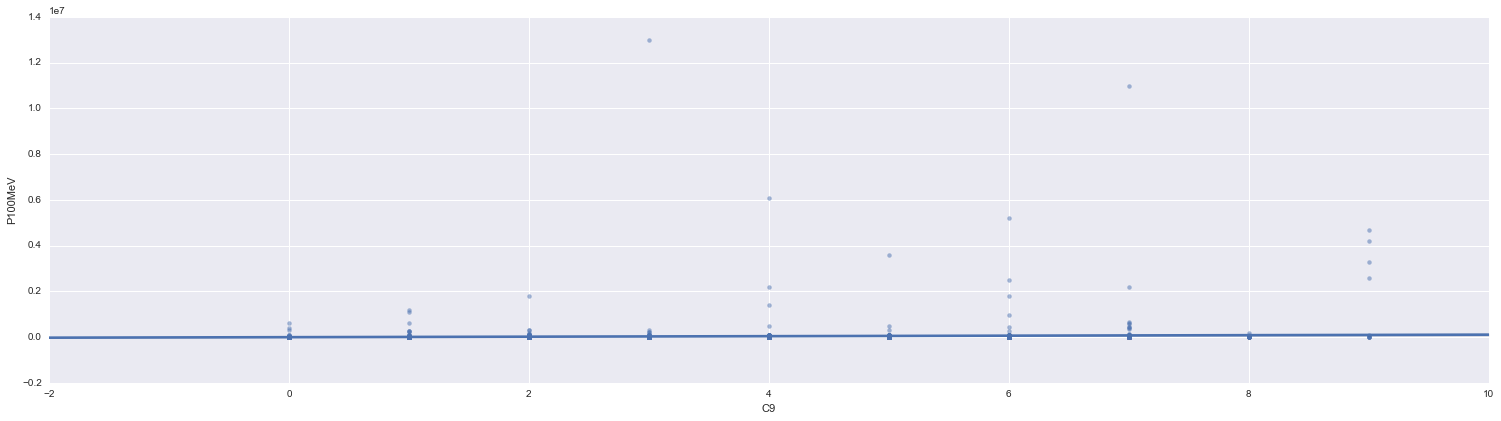

In [34]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.scatter( result.C9,result.P100MeV)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')

#plt.savefig('../images/Electron20MeV.png', bbox_inches='tight')

sns.lmplot(y='P100MeV', x='C9', data=result, aspect=3.5, scatter_kws={'alpha':0.5}, size=6)

In [35]:
result.groupby('C9').median()

,Year,Month,Day,Bartels,BDay,Kp0,Kp3,Kp6,Kp9,Kp12,...,Opt2,Opt3,P1MeV,P10MeV,P100MeV,E08MeV,E2MeV,LinearSpeed_max,20R_max,CME_daily_count
C9,,,,,,,,,,,,,,,,,,,,,
0,2008.0,7.0,16.0,2390.5,14.0,7.0,3.0,3.0,3.0,7.0,...,0.0,0.0,510000.0,17000.0,3700.0,4.100000e+09,9300000.0,406.0,624.5,3.0
1,2006.0,6.0,16.0,2358.5,13.5,17.0,13.0,13.0,13.0,13.0,...,0.0,0.0,440000.0,16000.0,3300.0,4.900000e+09,9900000.0,474.0,699.0,3.0
2,2005.0,6.0,16.0,2342.0,14.0,23.0,20.0,17.0,17.0,20.0,...,0.0,0.0,490000.0,16000.0,3200.0,6.000000e+09,12000000.0,485.0,695.0,4.0
3,2004.0,6.0,16.0,2331.0,14.0,27.0,27.0,23.0,20.0,23.0,...,0.0,0.0,685000.0,15000.0,3100.0,6.200000e+09,12000000.0,515.5,676.0,3.0
4,2004.0,7.0,15.0,2326.5,13.0,30.0,30.0,27.0,27.0,30.0,...,0.0,0.0,805000.0,15000.0,3100.0,7.750000e+09,14000000.0,507.0,659.5,3.0
5,2003.0,6.0,16.0,2321.0,14.0,33.0,33.0,33.0,33.0,33.0,...,0.0,0.0,1100000.0,15000.0,3000.0,6.450000e+09,14000000.0,546.5,710.5,3.0
6,2003.0,7.0,15.0,2318.0,13.5,40.0,40.0,40.0,37.0,40.0,...,0.0,0.0,1500000.0,15000.0,2900.0,6.150000e+09,13000000.0,579.0,738.0,3.0
7,2002.0,7.0,14.0,2310.5,15.0,43.0,50.0,50.0,50.0,50.0,...,0.0,0.0,6150000.0,20000.0,2800.0,2.950000e+09,7700000.0,614.0,800.0,4.0
8,2003.0,9.0,18.0,2318.0,16.0,60.0,70.0,73.0,63.0,70.0,...,0.0,0.0,12000000.0,310000.0,4800.0,2.600000e+09,6300000.0,797.0,919.0,4.0


Remove columns not used in the analysis

In [36]:
result.drop(['Year', 'Month', 'Day', 'Bartels','BDay','Kp0','Kp3','Kp6','Kp9','Kp12','Kp15','Kp18','Kp21'], axis=1, inplace=True)

In [37]:

print result.groupby('C9').median()
print result.groupby('C9').count()

    KpSum   Cp    ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0  C9+1  \
C9                                                                
0     5.0  0.0   24.0   1.0   1.0   1.0   1.0   0.0   0.0   0.0   
1    11.0  0.0   46.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2    15.0  0.0   48.0   1.0   2.0   2.0   2.0   2.0   2.0   2.0   
3    19.0  0.0   54.0   2.0   2.0   2.0   2.0   3.0   3.0   2.0   
4    22.0  0.0   55.5   2.0   2.0   2.0   2.0   3.0   4.0   3.0   
5    26.0  1.0   58.0   2.0   2.0   2.0   2.0   4.0   5.0   3.0   
6    31.0  1.0   59.0   2.0   2.0   2.0   2.0   4.0   6.0   5.0   
7    38.0  1.0   72.0   3.0   2.0   3.0   3.0   5.0   7.0   6.0   
8    48.0  1.0   67.0   2.0   2.0   1.0   3.0   6.0   8.0   5.0   
9    56.5  2.0  120.0   4.5   4.5   4.5   6.0   6.5   9.0   6.5   

         ...         Opt2  Opt3        P1MeV     P10MeV  P100MeV  \
C9       ...                                                       
0        ...          0.0   0.0     510000.0    17000.0   3

Create a response variable for logistic regression y=1 when C9 >=8, y=0 otherwise

In [38]:
result['y']=(result.C9>=8).map({True:1, False:0})

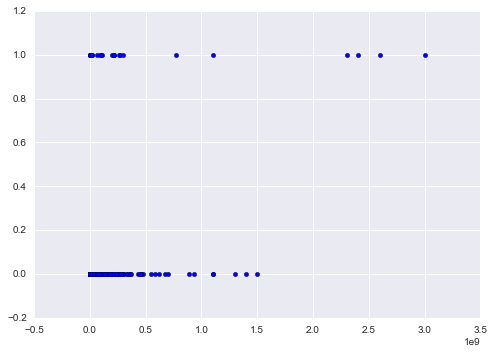

In [39]:
plt.scatter(result.P1MeV, result.y)

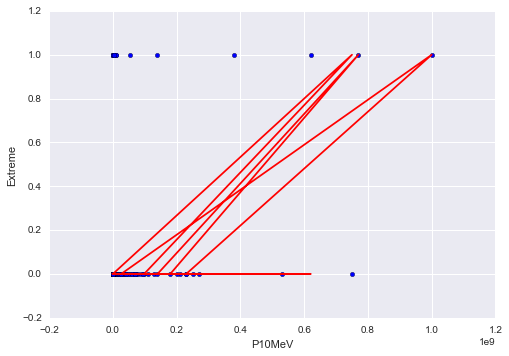

In [40]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
feature_cols = ['P10MeV']
X = result[feature_cols]
y = result.y
logreg.fit(X, y)
result['y_pred_class'] = logreg.predict(X)
plt.scatter(result.P10MeV, result.y)
plt.plot(result.P10MeV, result.y_pred_class, color='red')
plt.xlabel('P10MeV')
plt.ylabel('Extreme')

Summarize a week's prior data into every row.


In [41]:
# Get the dates of the extreme geomagnetic storms based on a C9 rating of 9.
# This is a collection of dates that we need to iteration through

results_filtered = result[result.C9 >= 0]
dt = results_filtered.index
dt

DatetimeIndex(['1997-01-01', '1997-01-02', '1997-01-03', '1997-01-04',
               '1997-01-05', '1997-01-06', '1997-01-07', '1997-01-08',
               '1997-01-09', '1997-01-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', name=u'Date', length=6574, freq='D')

In [42]:
# create a new list of dates shifted back in time by one week so that we can summarize solar activity over the past week
dt_shifted = dt.shift(-2,'D')

In [43]:
# For each event in the extreme events collection, summarize activity over the prior period (a week)
first_event = True
for event in dt:
    dt_range = pd.date_range(event, periods=3, freq='D')
    # create a dataframe with the information within this date range
    event_results = result.loc[dt_range]
    # create summary values that we'll append to the result set later
    C_sum = event_results.C.sum()
    M_sum = event_results.M.sum()
    X_sum = event_results.X.sum()
    S_sum = event_results.S.sum()
    ISN_sum =event_results.ISN.sum()
    Opt1_sum = event_results.Opt1.sum()
    Opt2_sum = event_results.Opt2.sum()
    Opt3_sum = event_results.Opt3.sum()
    CME_daily_count_sum = event_results.CME_daily_count.sum()
    LinearSpeed_max = event_results.LinearSpeed_max.max()
    TwentyR_max = event_results['20R_max'].max()
    P1MeV_sum = event_results.P1MeV.sum()
    P10MeV_sum = event_results.P10MeV.sum()
    P100MeV_sum = event_results.P100MeV.sum()
    # turn these values into a dictionary object that will turn into a dataframe and merge with the result set
    event_dict =  {'Date': event, 'C_sum' : C_sum, 'M_sum' : M_sum, 'X_sum': X_sum, 'S_sum': S_sum, 'ISN_sum': ISN_sum, 
                  'Opt1_sum': Opt1_sum, 'Opt2_sum': Opt2_sum,'Opt3_sum': Opt3_sum, 
                  'CME_daily_count_sum': CME_daily_count_sum, 'LinearSpeed_max_max': LinearSpeed_max, '20R_max_max' : TwentyR_max,
                  'P1MeV_sum' : P1MeV_sum, 'P10MeV_sum' : P10MeV_sum, 'P100MeV_sum' : P100MeV_sum}
    event_df = pd.DataFrame(event_dict, index=['Date'])
    event_df.index = event_df.Date
  
    if first_event:
        results_filtered = pd.concat([results_filtered, event_df], axis=1)
        first_event = False
        
    else:
        results_filtered.loc[event_df.Date, ['C_sum', 'M_sum', 'M_sum', 'X_sum', 'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum',
                                             'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max', '20R_max_max', 'P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']] = event_df[['C_sum', 'M_sum', 'M_sum', 'X_sum',
                                             'S_sum', 'ISN_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'CME_daily_count_sum', 'LinearSpeed_max_max',
                                            '20R_max_max', 'P1MeV_sum', 'P10MeV_sum','P100MeV_sum']]
results_filtered.drop(['Date'], axis=1, inplace=True)


In [44]:
print results_filtered.shape
results_filtered.dropna(inplace=True)
print results_filtered.shape

(6574, 51)
(6509, 51)


Try Kmeans clustering to categorize these events

In [87]:
# Create Feature Matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']
#feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
#                'LinearSpeed_max_max', '20R_max_max']
#feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']
#feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum', 'LinearSpeed_max_max', 'C9-1']
#feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']
feature_cols = ['P1MeV', 'P10MeV', 'P100MeV']
#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum', 'Opt2_sum']

X = results_filtered[feature_cols]

X_scaled = scaler.fit_transform(X)

n = 5 # number of clusters

In [88]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=n, random_state=1)
km.fit(X_scaled)
#km.labels_

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [89]:
results_filtered['cluster'] = km.labels_
#results_filtered.sort_values('cluster')

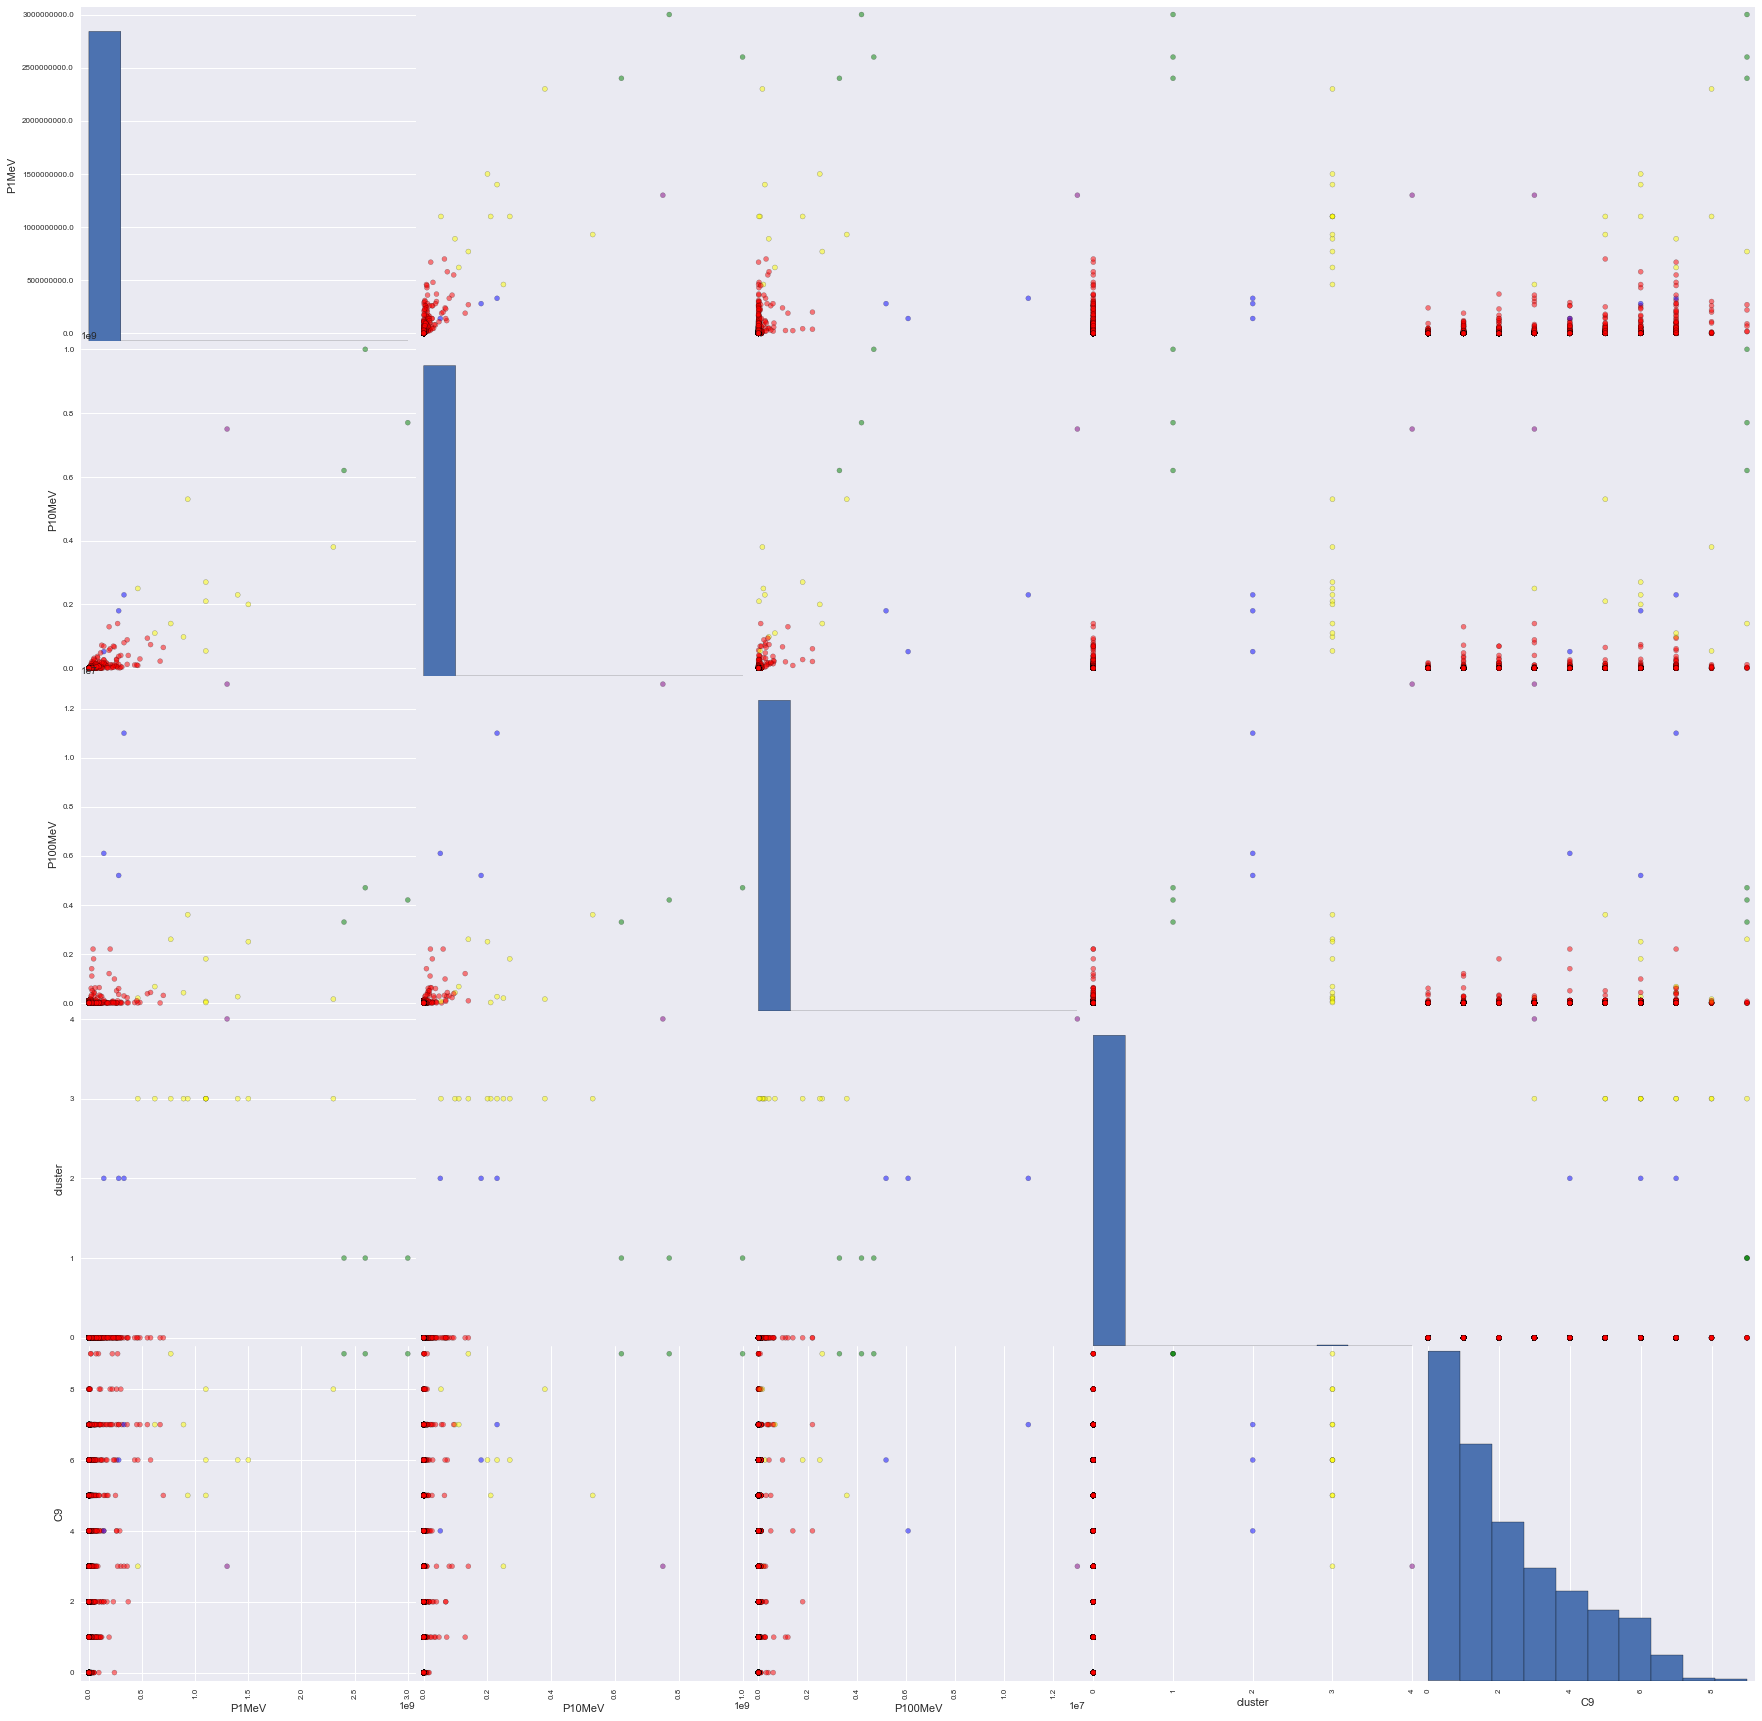

In [90]:
feature_cols_with_cluster = feature_cols; feature_cols_with_cluster.append('cluster'); feature_cols_with_cluster.append('C9')
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])
X_with_cluster = results_filtered[feature_cols_with_cluster]
scatter = pd.scatter_matrix(X_with_cluster, c=colors[results_filtered.cluster], figsize=(30,30), s=100)

In [99]:
print results_filtered.groupby('cluster').mean()

             KpSum        Cp        C9         ISN      C9-5      C9-4  \
cluster                                                                  
0        14.251117  0.148359  1.998459   52.948390  2.002927  2.002157   
1        54.000000  2.000000  9.000000  151.666667  5.666667  3.666667   
2        30.000000  0.666667  5.666667  123.666667  2.333333  5.000000   
3        33.545455  1.000000  6.363636  103.272727  2.727273  3.090909   
4        20.000000  0.000000  3.000000   95.000000  6.000000  4.000000   

             C9-3      C9-2      C9-1      C9_0    ...     \
cluster                                            ...      
0        2.005392  2.005700  2.003081  1.998459    ...      
1        1.333333  3.666667  6.000000  9.000000    ...      
2        5.666667  3.666667  5.666667  5.666667    ...      
3        2.727273  3.545455  4.181818  6.363636    ...      
4        7.000000  7.000000  5.000000  3.000000    ...      

         LinearSpeed_max_max     M_sum  Opt1_sum  Opt

In [107]:
print results_filtered[results_filtered.C9==9].groupby('cluster').count()

         KpSum  Cp  C9  ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0  ...    \
cluster                                                          ...     
0            6   6   6    6     6     6     6     6     6     6  ...     
1            3   3   3    3     3     3     3     3     3     3  ...     
3            1   1   1    1     1     1     1     1     1     1  ...     

         LinearSpeed_max_max  M_sum  Opt1_sum  Opt2_sum  Opt3_sum  \
cluster                                                             
0                          6      6         6         6         6   
1                          3      3         3         3         3   
3                          1      1         1         1         1   

         P100MeV_sum  P10MeV_sum  P1MeV_sum  S_sum  X_sum  
cluster                                                    
0                  6           6          6      6      6  
1                  3           3          3      3      3  
3                  1           1          1

In [93]:
print results_filtered[results_filtered.cluster==1].groupby('C9').count()
print results_filtered[(results_filtered.cluster==0) & (results_filtered.C9==9)]

    KpSum  Cp  ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0  C9+1   ...     M_sum  \
C9                                                             ...             
9       3   3    3     3     3     3     3     3     3     3   ...         3   

    Opt1_sum  Opt2_sum  Opt3_sum  P100MeV_sum  P10MeV_sum  P1MeV_sum  S_sum  \
C9                                                                            
9          3         3         3            3           3          3      3   

    X_sum  cluster  
C9                  
9       3        3  

[1 rows x 51 columns]
            KpSum   Cp  C9  ISN  C9-5  C9-4  C9-3  C9-2  C9-1  C9_0   ...    \
Date                                                                  ...     
1998-08-27   57.0  2.0   9  100   4.0   5.0   2.0   3.0   7.0     9   ...     
2001-03-31   61.0  2.0   9  205   0.0   6.0   7.0   5.0   3.0     9   ...     
2003-11-20   50.0  2.0   9   90   7.0   7.0   6.0   6.0   3.0     9   ...     
2004-07-25   58.0  2.0   9   57   2.0   

In [94]:
# http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib   - list of named colors
#colors = np.array(['red', 'green', 'blue', 'yellow', 'purple', 'black', 'pink', 'beige', 'brown', 'coral', 'darkgray', 'gold', 'olive'])
#pd.scatter_matrix(X, c=colors[results_filtered.cluster], figsize=(20,20), s=100)
#centers = results_filtered.groupby('cluster').mean()

#plt.figure(figsize=(20,20))
#plt.scatter(results_filtered.ISN_sum, results_filtered.LinearSpeed_max_max, c=colors[results_filtered.cluster], s=50)

# cluster centers, marked by "+"
#plt.scatter(centers.ISN_sum, centers.LinearSpeed_max_max, linewidths=3, marker='+', s=300, c=colors[centers.index])

# add labels
#plt.xlabel('ISN_sum')
#plt.ylabel('LinearSpeed_max_max')

Evaluate the Model using Silhoutte Coefficient

In [95]:
# calculate SC 
from sklearn import metrics
metrics.silhouette_score(X_scaled, km.labels_)

0.98973274228930219

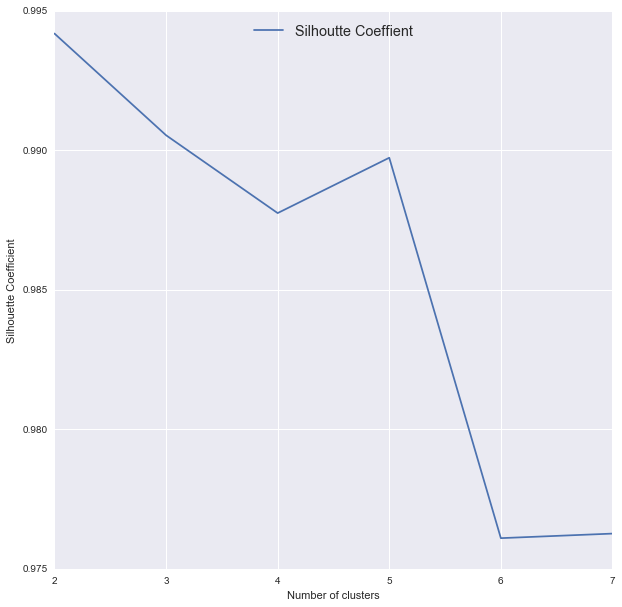

In [96]:
# calculate SC for K=2 through K=8
k_range = range(2, 8)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_scaled)
    scores.append(metrics.silhouette_score(X_scaled, km.labels_))

# plot the results
plt.figure(figsize=(10,10))
plt.plot(k_range, scores, Label = "Silhoutte Coeffient")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)
legend = plt.legend(loc='upper center', shadow=True, fontsize='large')
plt.savefig('../images/Kmeans.png', bbox_inches='tight')

Cluster Selection was made by looking for the first local maximum on the graph above.

Working with only the C9 >=8 data

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum']

SC = .346 with 5 clusters


feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 'LinearSpeed_max_max']

SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'CME_daily_count_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum', 'Opt2_sum', 'Opt3_sum', 
                'LinearSpeed_max_max', '20R_max_max']
                
SC = .370 with 6 clusters

feature_cols = ['ISN_sum', 'C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .435 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum']

SC = .488 with 3 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt1_sum']

SC = .420 with 7 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum']

SC = .556 with 11 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt3_sum']

SC = .513 with 5 clusters

#feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'Opt2_sum', 'Opt3_sum']

SC = .462 with 5 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'LinearSpeed_max_max']

SC = .441 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', '20R_max_max']

SC = .420 with 7 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-5']

SC = .360 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-4']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-3']

SC = .370 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-2']

SC = .369 with 3 clusters

feature_cols = ['C_sum', 'M_sum', 'S_sum', 'X_sum', 'C9-1']

SC = .369 with 3 clusters

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']

SC = .784 with 2 clusters

======================================================================
Working with the entire dataset C9>=0

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum']

SC = .91 with 8 clusters - but not able to isolate the C9>=8 into a cluster, using 7 days of history

Will try to shrink history down to 2 days

SC = .945 with 8 clusters - still not able to isolate

feature_cols = ['P1MeV_sum', 'P10MeV_sum', 'P100MeV_sum', 'LinearSpeed_max_max', 'C9-1']

SC = .932 with 2 clusters

